<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# CAPSTONE Part 3: Reinforcement Learning for Portfolio Allocation

# 1. Importing Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.models import load_model

import statsmodels.api as sm
from statsmodels import regression

import bz2
import _pickle as cPickle

import cvxopt as opt
from cvxopt import solvers

import warnings
warnings.filterwarnings('ignore')

# 2. Data Import

In [2]:
# Load data
assets = pd.read_csv('../data/S&P500.csv', index_col=0)

In [3]:
# Select data from start of 2020 onwards
assets = assets['2020-01-01':]

Note that we can use any time period available in our dataframe's date range (goes back to start of 2000)

In [4]:
# Check for columns with missing values
assets.isna().sum()[assets.isna().sum() > 0]

BRK.B    928
BF.B     928
CARR      53
CEG      516
GEHC     745
KVUE     840
OGN      344
OTIS      53
dtype: int64

In [5]:
# Calculate the fraction of missing values for each column and sort them in descending order
missing_fractions = assets.isnull().mean().sort_values(ascending=False)

# Print the top 5 columns with the highest fractions of missing values
missing_fractions.head()

BF.B     1.000000
BRK.B    1.000000
KVUE     0.905172
GEHC     0.802802
CEG      0.556034
dtype: float64

In [6]:
# Create a list of column names to drop, for columns with a missing value fraction greater than 30%
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

# Print length of drop_list
len(drop_list)

6

In [7]:
# Check stock tickers in drop_list
drop_list

['BF.B', 'BRK.B', 'CEG', 'GEHC', 'KVUE', 'OGN']

In [8]:
# Drop the identified stock ticker columns with a high percentage of missing values
assets.drop(labels=drop_list, axis=1, inplace=True)

In [9]:
# Check for remaining columns with missing values
assets.isna().sum()[assets.isna().sum() > 0]

CARR    53
OTIS    53
dtype: int64

In [10]:
# Fill in missing values using linear interpolation method
assets.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

In [11]:
# Check for missing values
assets.isna().sum().sum()

0

In [12]:
# Check shape
assets.shape

(928, 496)

There are 496 equities with 928 days worth of trading data

In [13]:
# Print first 5 rows
assets.head()

,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,44.557987,81.730194,75.656311,199.225388,57.028183,42.027313,334.429993,157.518600,17.999647,48.491768,...,194.497040,326.561310,141.707489,56.588825,76.319832,95.391975,259.140015,141.097382,46.221893,130.801010
2020-01-03,44.166237,80.733818,74.938179,198.893600,57.047626,41.945290,331.809998,157.185669,17.792955,48.155460,...,194.544662,322.724548,139.605545,56.860981,76.769051,95.093201,256.049988,140.728500,45.569641,130.820496
2020-01-06,44.446072,81.156807,75.529587,197.594803,58.088043,41.617165,333.709991,157.398392,17.999647,48.019119,...,194.782684,319.721405,139.329239,56.779327,76.272049,95.037186,258.010010,139.915192,45.014343,129.816177
2020-01-07,44.147579,80.705627,75.098717,193.328720,58.671448,41.115868,333.390015,155.493195,18.062548,47.564651,...,194.382797,320.053040,139.990402,56.661396,75.985321,95.205238,256.470001,139.792267,44.741096,130.254959
2020-01-08,44.082287,81.034622,75.630959,193.707962,58.224167,40.660126,337.869995,156.954468,18.026604,47.710087,...,194.601791,323.435120,140.868683,56.606968,76.243370,95.373291,247.639999,141.466187,45.181812,129.972183


In [14]:
# Randomly sample 10 different columns (equities), note that we can use any number of equities up to the number of columns in the dataframe
# Also if you run this code, you will get a different list of equities
selected_columns = assets.sample(n=10, axis=1)

In [15]:
# Print first 5 rows of our selected_columns dataframe
selected_columns.head()

,HIG,GRMN,PFG,TSN,AME,INVH,SYK,XRAY,AXP,WM
Date,,,,,,,,,,
2020-01-02,55.566319,90.040283,48.036705,81.496056,98.409988,27.018183,202.191467,54.796288,119.796921,107.085220
2020-01-03,55.283703,89.463448,47.329899,82.048576,98.546677,27.577433,201.365189,54.189899,118.607056,108.125900
2020-01-06,55.137833,89.445152,47.407482,81.659073,98.654053,27.678284,203.891998,54.488277,118.093002,108.688393
2020-01-07,54.645535,89.307800,47.709152,80.472488,99.220299,27.082361,201.394012,54.777046,117.474289,108.763405
2020-01-08,54.937260,88.813377,47.916035,80.970680,99.444870,27.357403,202.421997,55.354553,119.501839,108.829018


# 3. Create The Classes Required For Reinforcement Learning

## 3.1 Stock Environment Class

The StockEnvironment class is a simulation environment for equities. This class has following key functions:

1. Function getState: This function returns the state in addition to either the covariance matrix of the portfolio based on a lookback period or the historical return data depending on whether is_cov_matrix or is_raw_time_series flag is set to True
2. Function getReward: This function returns the reward which is the sharpe ratio of the portfolio given the portfolio weights and lookback period

In [16]:
# Define a class called StockEnvironment
class StockEnvironment:

    def __init__(self, data=selected_columns, capital=1e6):
        """
        Initialize a StockEnvironment instance.

        Parameters:
        - data (dataframe of stock returns (prices)): 
        - capital (float): Initial capital for the environment (default: 1e6).

        This constructor sets up the initial state of the StockEnvironment instance
        by specifying the pandas dataframe data containing stock prices and the initial capital. 
        """
        self.capital = capital
        self.data = data

    
    # Preprocess the state if needed. This method is a placeholder for any preprocessing steps that might be required for the state data before using it
    # If no preprocessing is needed, it simply returns the state as is
    def preprocess_state(self, state):
        return state

    
    def get_state(self, t, lookback, is_cov_matrix=True, is_raw_time_series=False):
        """
        Get the state data for a given time 't' and lookback period.

        Parameters:
        - t (int): Current time index.
        - lookback (int): Number of historical time periods to consider.
        - is_cov_matrix (bool): If True, return the covariance matrix of returns (default: True).
        - is_raw_time_series (bool): If True, return historical return data (default: False).

        This method retrieves the state data for a given time 't' and specified lookback period.
        The state data can be returned as a covariance matrix of returns or the historical return data.
        If 'is_cov_matrix' is True, the covariance matrix is returned; if 'is_raw_time_series' is True,
        the historical return data is returned after preprocessing.
        """
        assert lookback <= t # Check that the lookback period is valid

        # Extract the historical data for the specified lookback period
        decision_making_state = self.data.iloc[t - lookback:t]

        # If 'is_raw_time_series' is True, return the historical return data after preprocessing
        if is_raw_time_series:
            return self.preprocess_state(decision_making_state)

        # If 'is_cov_matrix' is True, calculate and return the covariance matrix
        if is_cov_matrix:
            # Calculate the percentage change in asset prices and drop NaN values
            decision_making_state = decision_making_state.pct_change().dropna()
            # Return the covariance matrix
            return decision_making_state.cov()

    
    def get_reward(self, action, action_t, reward_t):
        """
        Calculate the reward based on the action taken and the observed outcomes.

        Parameters:
        - 'action': NumPy array representing portfolio allocation weights for different assets.
        - 'action_t': The time index when the action (portfolio allocation) is taken.
        - 'reward_t': The time index when the reward is observed.

        This method calculates the reward based on the given action (portfolio allocation weights)
        and the observed outcomes between two time points, 'action_t' and 'reward_t'. It uses a
        portfolio model to calculate the reward. The reward is a combination of portfolio returns
        and the Sharpe ratio. The Sharpe ratio measures the risk-adjusted return.

        Returns:
        - 'reward': The calculated reward based on the action and observed outcomes.
        - 'sharpe': The Sharpe ratio of the portfolio.
        """
        def portfolio(returns, weights):
            """
            Calculate portfolio statistics for a given set of returns and allocation weights.

            Parameters:
            - returns (pd.DataFrame): Time series of asset returns.
            - weights (np.array): Portfolio allocation weights.

            Returns:
            - Portfolio statistics including expected return, volatility, and Sharpe ratio.
            """
            weights = np.array(weights)
            rets = returns.mean()
            covs = returns.cov()
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        # Extract data for the specified time period
        data_period = self.data[action_t:reward_t]
        weights = action

        # Calculate percentage returns for the selected time period
        returns = data_period.pct_change().dropna()

        # Calculate the Sharpe ratio for the portfolio
        sharpe = portfolio(returns, weights)[-1]
        
        # Create an array of Sharpe ratios with the same length as the number of assets
        sharpe = np.array([sharpe] * len(self.data.columns))
        
        # Calculate the weighted sum of returns and return the result along with Sharpe ratios
        return np.dot(returns, weights), sharpe


## 3.2 Agent Class

The agent class consists of the following components:

1. Constructor
    - The constructor is defined as init function and contains important parameters such as discount factor (gamma) for the reward function, epsilon for the ε-greedy approach, portfolio size, and action size. The number of actions is set at three (i.e., hold, buy, or sell). The input parameter of this function also consists of a is_eval parameter, which defines whether training is ongoing. This variable is changed to True during the evaluation/testing phase
    - **Gamma (discount factor):** Decaying gamma will have the agent prioritize short-term rewards as it learns what those rewards are and place less emphasis on long-term rewards. Lowering the discount factor in this case study may cause the algorithm to focus on the long-term rewards
    - **Epsilon:** The epsilon variable drives the exploration versus exploitation property of the model. The more we get to know our environment, the less random exploration we want to do. When we reduce epsilon, the likelihood of a random action becomes smaller, and we take more opportunities to benefit from the high valued actions that we already discovered
2. _model function
    - This function is built using the Keras Python library. **The number of layers and nodes of the deep learning model** can be modified for better training and a more optimal Q-value.
3. act function
    - Get portfolio allocation weights
4. expReplay function
    - The function expReplay is the key function, where the neural network is trained based on the observed experience. This function implements the Experience replay mechanism. Experience replay stores a history of state, action, reward, and next state transitions that are experienced by the agent. It takes a minibatch of the observations (replay memory) as an input and updates the deep learning based Q-learning model weights by minimizing the loss function. The epsilon greedy approach implemented in this function prevents overfitting

In [17]:
class Agent:
    
    def __init__(self, portfolio_size, is_eval=False, allow_short=True, model_name=''):
        """
        Initialize an Agent instance for portfolio management.

        Parameters:
        - portfolio_size (int): Number of assets or instruments in the portfolio.
        - is_eval (bool): Flag indicating whether the agent is in evaluation mode (default: False).
        - allow_short (bool): Flag indicating whether short-selling is allowed (default: True).

        This constructor sets up the agent's initial configuration, including portfolio size,
        evaluation mode, and short-selling allowance. It also initializes various hyperparameters,
        such as epsilon (exploration factor), memory for experience replay, and the deep learning model.
        """
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size)
        self.action_size = 3  # hold, buy or sell
        self.model_name = model_name
        
        self.memory4replay = []  # Memory for experience replay
        self.is_eval = is_eval  # Flag for evaluation mode

        self.alpha = 0.5  # Learning rate
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1  # Exploration factor
        self.epsilon_min = 0.01  # Minimum exploration factor
        self.epsilon_decay = 0.99  # Exploration decay rate
        
        self.model = self._model()  # Initialize the deep learning model
        self.model = load_model("../data/" + model_name) if is_eval else self._model()
        
        
    def _model(self):
        """
        Build and compile the deep learning model for the agent.

        Returns:
        - model (keras.models.Model): Compiled deep learning model.

        This method defines the architecture of the deep learning model used by the agent for portfolio
        allocation. The model consists of a neural network with multiple dense layers. It outputs a list
        of predictions for each asset in the portfolio. The model is compiled using the mean squared error
        (MSE) loss function and the Adam optimizer.

        Input:
        - inputs (keras.layers.Input): Input layer with the shape defined by self.input_shape.
        - x (keras.layers.Flatten): Flatten the input data.
        - x (keras.layers.Dense): Fully connected layer with 100 units and ELU activation.
        - x (keras.layers.Dropout): Dropout layer with a dropout rate of 0.5.
        - x (keras.layers.Dense): Fully connected layer with 50 units and ELU activation.
        - x (keras.layers.Dropout): Dropout layer with a dropout rate of 0.5.
    
        Output:
        - model (keras.models.Model): The compiled deep learning model with 'self.portfolio_size' output
          heads, each predicting 'self.action_size' actions for a specific asset in the portfolio.

        """
        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)

        # Create Predictions for Asset Weights
        predictions = []
        for i in range(self.portfolio_size):
            # Create a dense layer for predicting the weight of the current asset
            asset_dense = Dense(self.action_size, activation='linear')(x)
            predictions.append(asset_dense)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        
        return model

        
    def nn_pred_to_weights(self, pred, allow_short=True):
        """
        Convert neural network predictions to portfolio weights.

        Parameters:
        - pred (numpy.ndarray): Predictions from the neural network.
        - allow_short (bool): Whether short selling is allowed (default: True).

        Returns:
        - weights (numpy.ndarray): Portfolio weights.
        - saved_min (float or None): Minimum weight (saved if short selling is not allowed).
        - saved_sum (float): Sum of weights.

        This method converts the neural network predictions into portfolio weights, considering whether short selling
        is allowed or not. If short selling is allowed, the weights are calculated as the absolute values of the
        network predictions normalized to sum to 1. If short selling is not allowed, the minimum weight is saved and
        subtracted from all weights to ensure they are non-negative and still sum to 1.
        """
        # Initialize an array to store asset weights
        weights = np.zeros(len(pred))
        # Find the index of the maximum prediction for each asset
        raw_weights = np.argmax(pred, axis=-1)

        # Initialize a variable to save the minimum weight (for short selling)
        saved_min = None

        # Loop through the assets and assign weights based on predictions
        for e, r in enumerate(raw_weights):
            if r == 0:  # Hold
                weights[e] = 0
            elif r == 1:  # Buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])
    
        # Adjust weights to ensure non-negative values if short selling is not allowed
        if not allow_short:
            weights += np.abs(np.min(weights)) # Ensure all weights are non-negative
            saved_min = np.abs(np.min(weights)) # Save the absolute minimum weight
            saved_sum = np.sum(weights) # Calculate the sum of weights
        else:
            saved_sum = np.sum(np.abs(weights))

        # Normalize weights to ensure they sum to 1
        weights /= saved_sum
        
        # Return the calculated weights along with saved minimum and sum
        return weights, saved_min, saved_sum


    def act(self, state):
        """
        Select an action (get portfolio allocation weights) based on the current state.

        Parameters:
        - state (pd.DataFrame): The current state containing asset prices.

        Returns:
        - weights (np.array): Portfolio allocation weights.
        - saved_min (float or None): Minimum weight (for short selling).
        - saved_sum (float): Sum of weights after adjustments.

        This method determines the action (portfolio allocation) to take based on the current state.
        If the agent is in the exploration phase (not in evaluation mode) and a random number falls below
        the exploration probability (epsilon), a random portfolio allocation is generated. If short selling 
        is not allowed, adjustments are made to ensure non-negative weights. The method returns the calculated 
        weights along with saved minimum and saved sum for reference.
        
        Otherwise, the action is determined using the neural network model. The 'nn_pred_to_weights' function 
        is used to convert the neural network predictions into portfolio allocation weights. 
        """
        if not self.is_eval and random.random() <= self.epsilon:
            # Generate a random portfolio allocation with a normal distribution
            weights = np.random.normal(0, 1, size=(self.portfolio_size,))
            
            saved_min = None
            
            # Adjust weights for non-negative values if short selling is not allowed
            if not self.allow_short:
                weights += np.abs(np.min(weights)) # Ensure all weights are non-negative
                saved_min = np.abs(np.min(weights)) # Save the absolute minimum weight
                
            saved_sum = np.sum(weights) # Calculate the sum of weights
            weights /= saved_sum # Normalize weights to sum to 1
            return weights, saved_min, saved_sum
    
        # Use the neural network to make predictions and convert them to weights
        pred = self.model.predict(np.expand_dims(state.values, 0))
        # Convert the predictions into portfolio weights using the nn_pred_to_weights function
        return self.nn_pred_to_weights(pred, self.allow_short)

    
    # Define the experience replay method for updating the agent's Q-function
    def expReplay(self, batch_size):
        """
        Experience replay to update the agent's Q-function using stored memories.
    
        Parameters:
        - batch_size (int): Size of the batch used for updating the Q-function.
    
        This method performs experience replay to update the agent's Q-function based on stored memories.
        It iterates through the memories, extracts the state, action, reward, and whether the episode is done.
        The Q-function is updated based on the Q-learning algorithm.
    
        The 'weights_to_nn_preds_with_reward' function is used to calculate the Q-values for each action.
        The 'restore_Q_from_weights_and_stats' function converts the action format back to weights for Q-value calculation.
        If the episode is not done, the Q-values are updated using the Q-learning formula.
    
        Finally, the Q-values are used to update the current Q-function using a deep learning approach.
        The agent's exploration probability (epsilon) is also updated using epsilon decay.
        """
        def weights_to_nn_preds_with_reward(action_weights, reward, Q_star=np.zeros((self.portfolio_size, self.action_size))):

            """
            Calculate Q-values with rewards based on action weights and Q* values.
        
            Parameters:
            - action_weights (numpy.ndarray): Action weights representing the portfolio allocation.
            - reward (numpy.ndarray): Rewards associated with each asset in the portfolio.
            - Q_star (numpy.ndarray, optional): Q* values representing the expected future rewards (default: zeros).
        
            Returns:
            - Q (numpy.ndarray): Q-values for each asset-action pair.
        
            This function calculates the Q-values based on the action weights, rewards, and Q* values.
            It iterates through each asset in the portfolio and updates the Q-values according to the
            action weights and rewards. The Q* values represent the expected future rewards. The resulting
            Q-values represent the estimated total rewards for each asset-action pair.
            """
            Q = np.zeros((self.portfolio_size, self.action_size))
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])
            return Q
            
        def restore_Q_from_weights_and_stats(action):
            """
            Restore the action weights from the provided action tuple.
        
            Parameters:
            - action (tuple): A tuple containing action weights, minimum value, and sum of action weights.
        
            Returns:
            - action_weights (numpy.ndarray): The restored action weights.
        
            This function takes a tuple `action` as input, which includes action weights, minimum value, and sum
            of action weights. It restores and returns the action weights by adjusting them based on the provided
            statistics. If `action_min` is not `None`, it subtracts `action_min` from the action weights to ensure
            non-negativity.
            """
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum
            if action_min is not None:
                action_weights = action_weights - action_min
            return action_weights
    
        for (s, s_, action, reward, done) in self.memory4replay:
            # Restore action weights from the action tuple
            action_weights = restore_Q_from_weights_and_stats(action)
    
            # Calculate Q-values using Q-learning
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values
    
            if not done:
                # Predict Q-values for the next state (s_) using the neural network
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                # Update Q-learned value with Q_star if not in the terminal state
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))

            # Reshape Q-learned values for compatibility
            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            # Predict Q-values for the current state (s) using the neural network
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            # Update Q-values with a blend of Q-learned and Q-current values
            Q = [np.add(a * (1 - self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
    
            # Update current Q-function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)
    
        # Update exploration probability (epsilon) with epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Determining The Mean Variance Optimized Portfolio Allocation Weights For A Randomly Chosen Investor

In [18]:
# Function to load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [19]:
# Load the saved risk tolerance prediction model from disk
loaded_model = decompress_pickle('../data/final_model.pbz2')

In [20]:
# Load the data. This is the csv file containing the attributes used to predict risk tolerance, and also includes the target (risk tolerance)
investors = pd.read_csv('../data/attributes_risk_tolerance.csv')

In [21]:
# Randomly sample one row from the dataframe. This represents a random investor. 
random_row = investors.sample(n=1)
# Use the previously ssaved risk tolerance prediction model to predict the value of risk tolerance
risk_tolerance = loaded_model.predict(random_row.iloc[:, :-1])
# Convert risk tolerance to a scale of 0 to 100 and round the value to 2 decimal places
risk_tolerance = round(float(risk_tolerance[0]*100),2)
# Print the value for risk_tolerance, resample (run this code block again) if risk_tolerance is 0.00
risk_tolerance

63.67

In [22]:
# Take the column names (stock names) of the selected_columns dataframe and convert this to a list
column_names = list(selected_columns.columns)
# Print the list of stock names
column_names

['HIG', 'GRMN', 'PFG', 'TSN', 'AME', 'INVH', 'SYK', 'XRAY', 'AXP', 'WM']

In [23]:
# Define a function called get_asset_allocation that calculates optimal asset allocation based on risk tolerance
def get_asset_allocation(risktolerance, stock_ticker):    
    # Select the subset of assets based on the provided stock_ticker
    assets_selected = assets.loc[:,stock_ticker]
    # Calculate the percentage change in asset returns and convert it into a NumPy array
    return_vec = np.array(assets_selected.pct_change().dropna(axis=0)).T
    # Determine the number of assets in the selected subset
    n = len(return_vec)
    # Convert the array of returns into a NumPy matrix
    returns = np.asmatrix(return_vec)
    # Calculate one minus the risk tolerance
    mus = 1 - risktolerance
    
    # Convert return and covariance data to CVXOPT matrices for optimization
    S = opt.matrix(np.cov(return_vec)) # Covariance matrix of returns
    pbar = opt.matrix(np.mean(return_vec, axis=1)) # Mean returns
    
    # Create constraint matrices for the optimization problem
    G = -opt.matrix(np.eye(n))   # Negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Use quadratic programming to calculate efficient portfolio weights
    portfolios = solvers.qp(mus*S, -pbar, G, h, A, b)
    # Extract the allocation weights from the optimization result
    w = portfolios['x'].T
    # Create a DataFrame to store the asset allocation weights
    allocation = pd.DataFrame(data = np.array(portfolios['x']), index = assets_selected.columns)

    # Calculate the final returns based on the allocation weights
    returns_final=(np.array(assets_selected) * np.array(w))
    # Calculate the cumulative returns of the portfolio
    returns_sum = np.sum(returns_final,axis =1)
    # Create a DataFrame to store the cumulative returns, starting at 100 for reference
    returns_sum_pd = pd.DataFrame(returns_sum, index = assets.index)
    returns_sum_pd = returns_sum_pd - returns_sum_pd.iloc[0,:] + 100
    
    # Return the asset allocation weights and cumulative returns
    return allocation, returns_sum_pd

In [24]:
# Use the get_asset_allocation function to calculate the optimal asset allocation for a given risk tolerance and a given list of stock names
# We do not need the variable for the cumulative returns dataframe
allocation, _ = get_asset_allocation(risk_tolerance, column_names)

     pcost       dcost       gap    pres   dres
 0: -9.5642e-03 -1.0167e+00  1e+00  0e+00  4e+00
 1: -9.6055e-03 -2.6738e-02  2e-02  1e-16  6e-02
Terminated (singular KKT matrix).


In [25]:
# Print allocation
allocation

,0
HIG,0.104653
GRMN,0.095388
PFG,0.108850
TSN,0.094490
AME,0.099450
INVH,0.097584
SYK,0.100369
XRAY,0.099035
AXP,0.108426
WM,0.091756


In [26]:
# Assign the asset weights (column '0') to a list called mpt_weights
mpt_weights = list(allocation[0].values)

# 5. Training The RL Agent

The algorithm is trained using Deep Q Learning and the components of the reinforcement learning algorithm are:

1. **Agent:** Robo advisor
2. **Action:** The DQN model provides the Q-values which is further converted into portfolio weights, so the possible actions are buy, sell or hold which reassigns the portfolio weights
3. **Reward function:** Sharpe ratio
4. **State:** The state is the covariance matrix of the assets based on a chosen lookback period
5. **Environment:** The stock exchange

The algorithm determines the optimal portfolio allocation depending upon the current state of the portfolio of assets. 


**Episode and batch size**

A higher number of episodes and smaller batch size in the training set will lead to better training and a more optimal Q-value. However, there is a trade-off, as increasing the number of episodes and batch size increases the total training time.

**Window size**

Window size determines the number of market days to consider to evaluate the state. This can be increased in case we want the state to be determined by a greater number of days in the past.

In [27]:
# Variable for number of market days to consider to evaluate the state
window_size = 90
# Variable for number of training episodes
episode_count = 10
# Variable for batch size for memory reply
batch_size = 32
# Variable for when the RL agent rebalances portfolio weights
rebalance_period = 45 

In [28]:
# n_assets is 10, or in this case, the number of columns in the dataframe (number of stocks)
n_assets = selected_columns.shape[1]
# Instantiate the Agent class wih n_assets as the portfolio_size argument
agent = Agent(n_assets)
# Instantiate the StockEnvironment class with the selected_columns dataframe
env = StockEnvironment(selected_columns)

Episode 1/10 epsilon 1


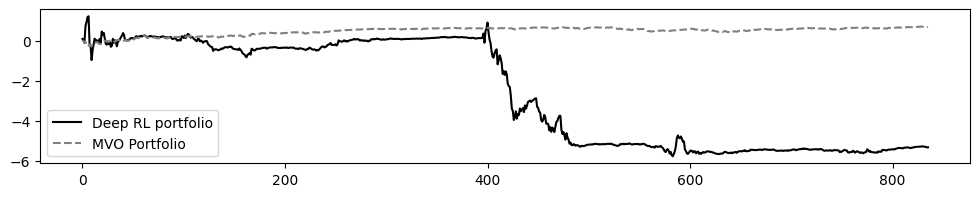

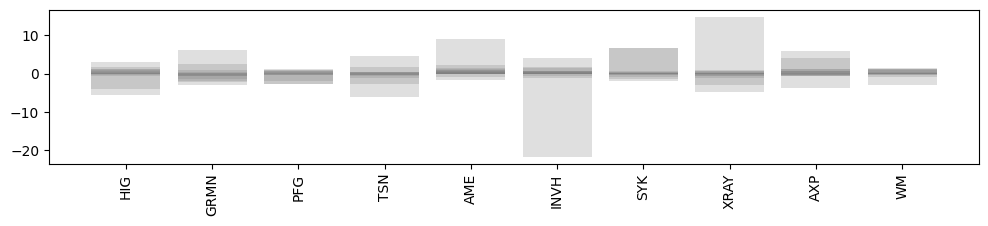

Episode 2/10 epsilon 1
1/1 [==============================] - 0s 20ms/step


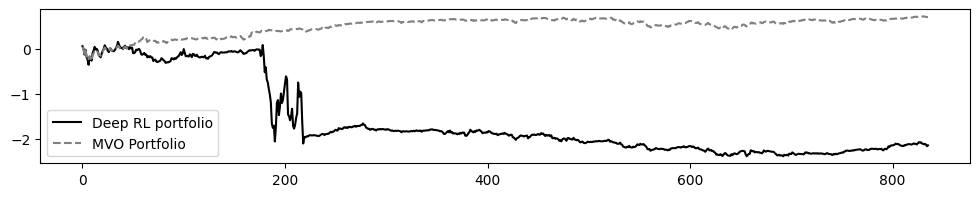

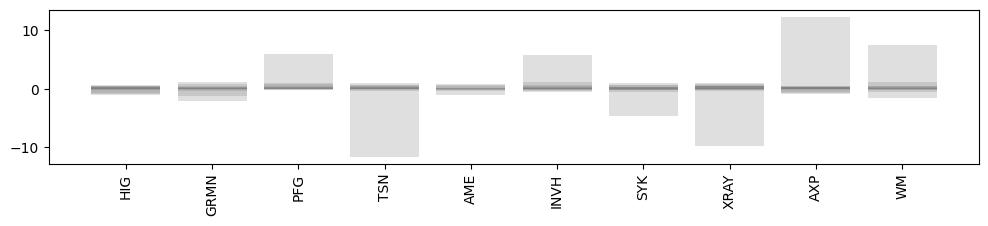

Episode 3/10 epsilon 0.99


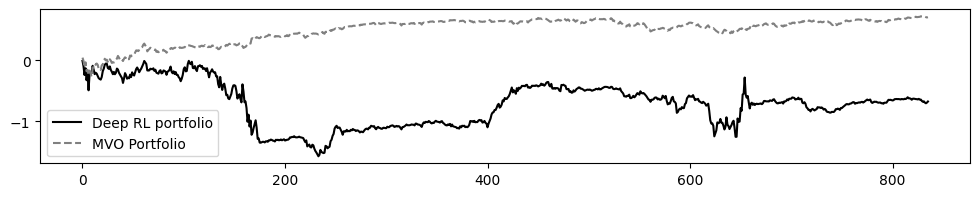

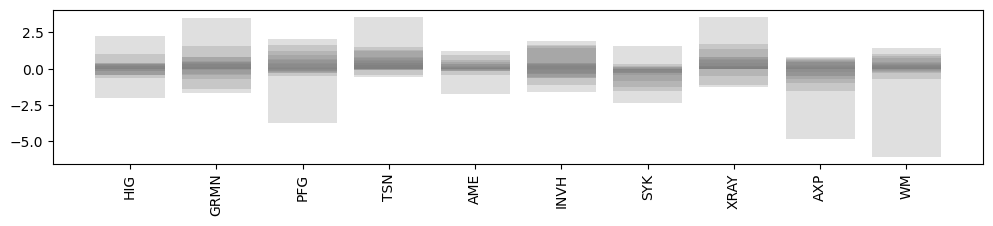

Episode 4/10 epsilon 0.99
1/1 [==============================] - 0s 19ms/step


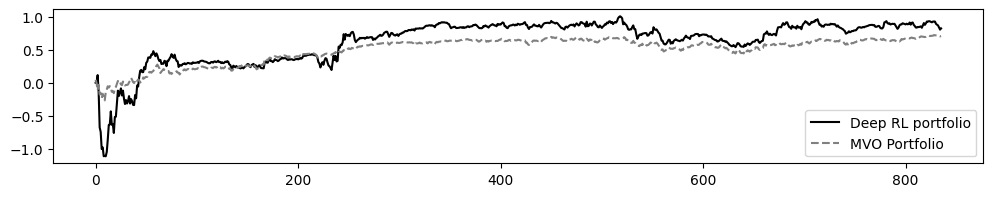

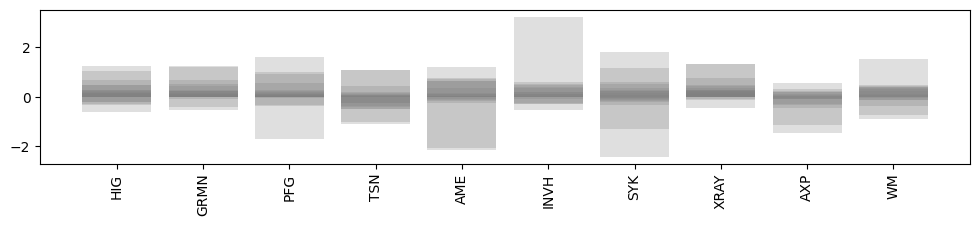

Episode 5/10 epsilon 0.9801


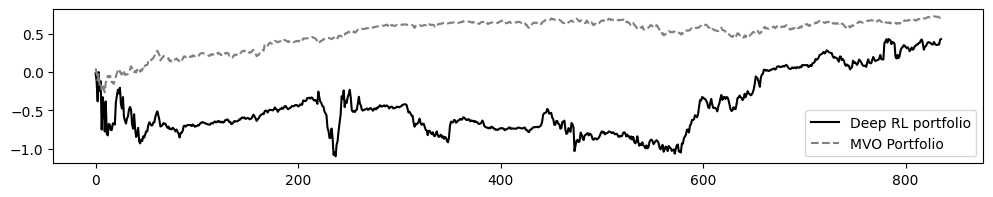

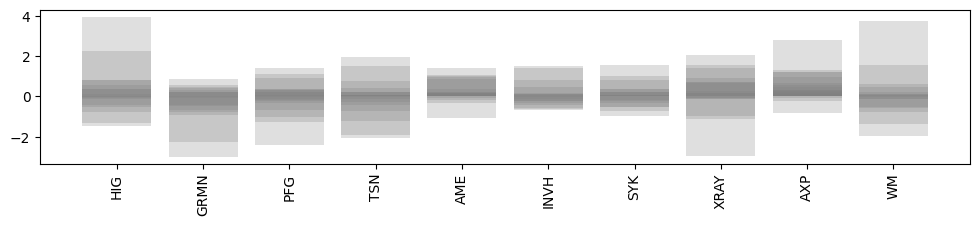

Episode 6/10 epsilon 0.9801
1/1 [==============================] - 0s 17ms/step


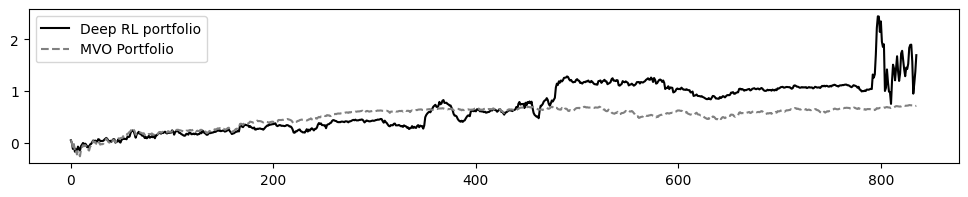

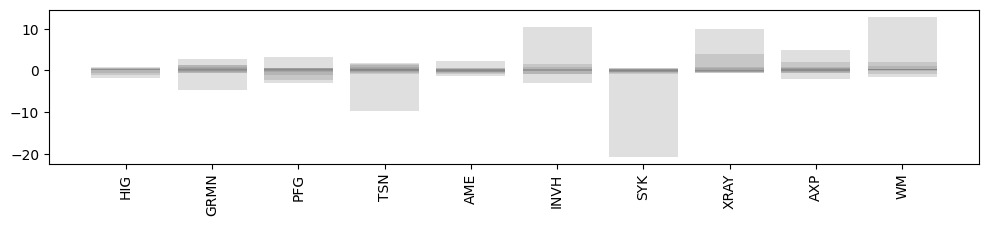

Episode 7/10 epsilon 0.9702989999999999
1/1 [==============================] - 0s 18ms/step


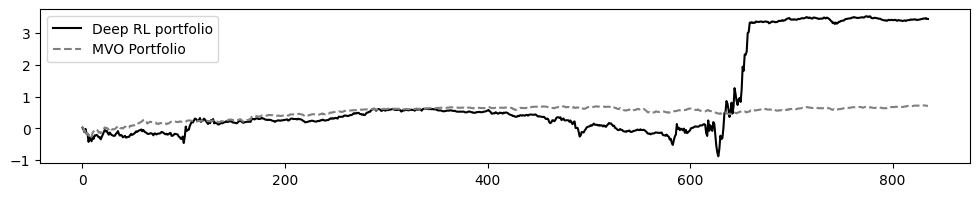

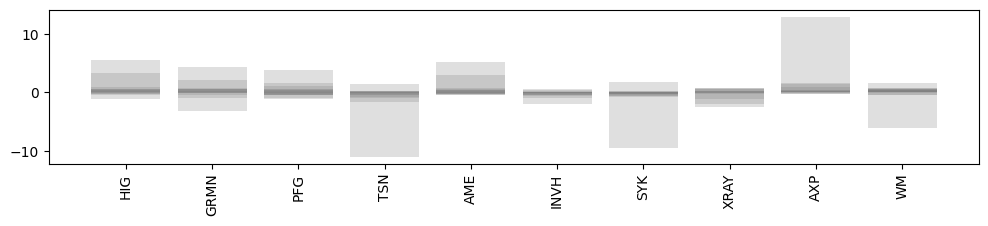

Episode 8/10 epsilon 0.96059601


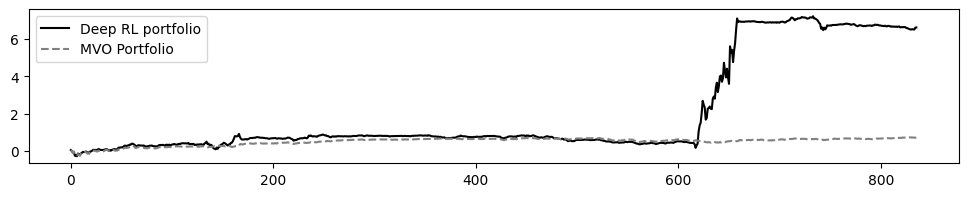

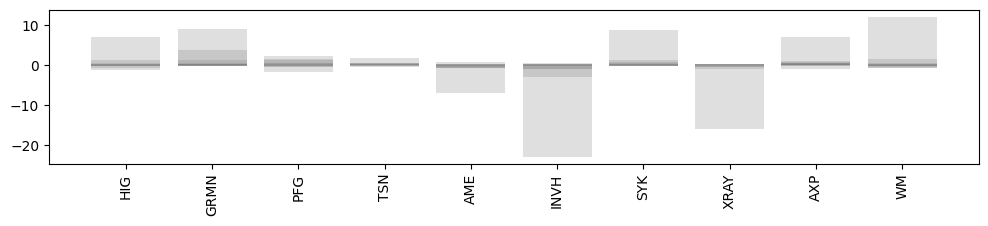

Episode 9/10 epsilon 0.96059601
1/1 [==============================] - 0s 17ms/step


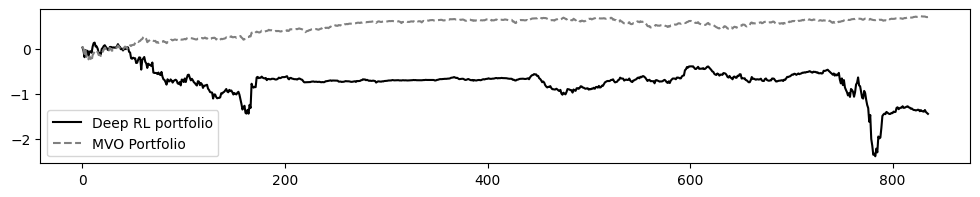

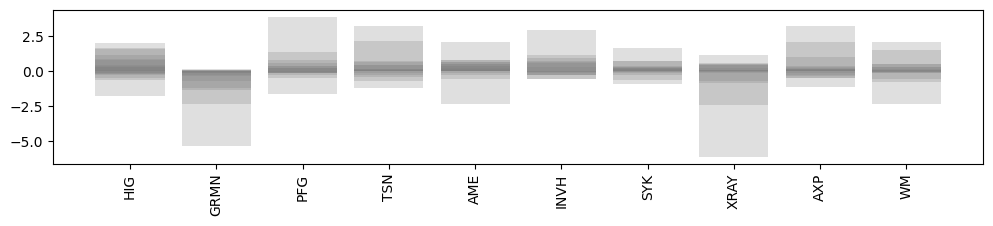

Episode 10/10 epsilon 0.9509900498999999
1/1 [==============================] - 0s 18ms/step


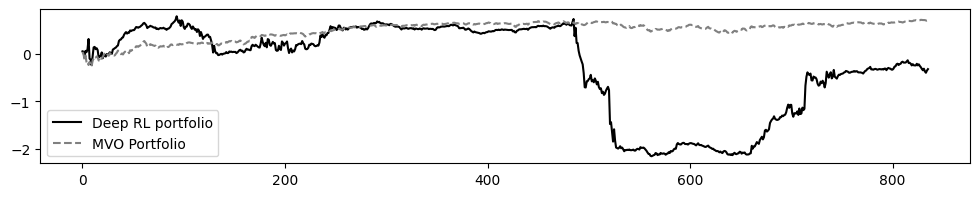

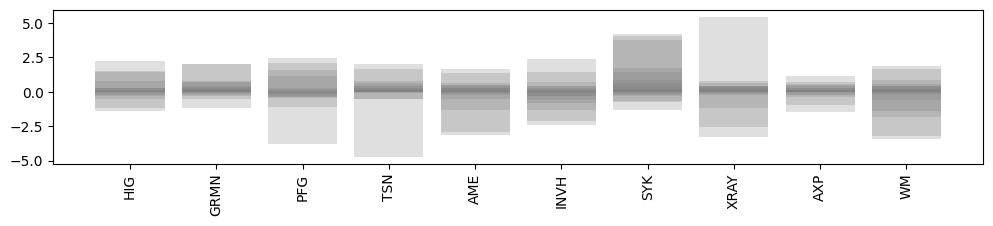

INFO:tensorflow:Assets written to: ../data/model_rl10\assets


INFO:tensorflow:Assets written to: ../data/model_rl10\assets


In [39]:
# Loop through episodes
for e in range(1, episode_count + 1):
    # Initialize episode-specific variables
    agent.is_eval = False
    data_length = len(env.data)
    
    # Lists to store cumulative returns for the agent's portfolio and an MPT (Modern Portfolio Theory) weighted portfolio
    returns_history = []
    returns_history_mpt = []
    
    # Lists to store rewards obtained by the agent and an MPT weighted portfolio
    rewards_history = []
    rewards_history_mpt = []
    
    # List to store the portfolio allocation actions
    actions_to_show = []
    
    # Print the current episode number and agent's epsilon value
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    # Initialize the state for the current episode
    s = env.get_state(np.random.randint(window_size + 1, data_length - window_size - 1), window_size)
    
    # Loop through time steps within the episode
    for t in range(window_size, data_length, rebalance_period):
        # Calculate the start date of the current period
        date1 = t - rebalance_period
        
        # Get the current state and select an action using the agent
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])
        
        # Calculate portfolio returns and rewards based on the selected action
        weighted_returns, reward = env.get_reward(action[0], date1, t)
        
        # Calculate returns and rewards for an MPT weighted portfolio
        weighted_returns_mpt, reward_mpt = env.get_reward(mpt_weights, date1, t)
        
        rewards_history.append(reward)
        rewards_history_mpt.append(reward_mpt)
        
        # Extend lists with returns for the agent's portfolio and the MPT weighted portfolio
        returns_history.extend(weighted_returns)
        returns_history_mpt.extend(weighted_returns_mpt)

        # Check if the episode is done
        done = True if t == data_length else False
        
        # Append the current state, action, reward, and done flag to the agent's memory
        agent.memory4replay.append((s, s_, action, reward, done))
        
        # Perform experience replay when the memory size is sufficient
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    # Calculate cumulative returns for the agent's portfolio and the MPT weighted portfolio
    rl_result = np.array(returns_history).cumsum()
    mpt_result = np.array(returns_history_mpt).cumsum()

    # Plot cumulative returns for the agent and the MPT weighted portfolio
    plt.figure(figsize=(12, 2))
    plt.plot(rl_result, color='black', ls='-', label='Deep RL portfolio')
    plt.plot(mpt_result, color='grey', ls='--', label='MVO Portfolio')
    plt.legend()
    plt.show()
    
    # Plot portfolio allocation actions
    plt.figure(figsize=(12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(n_assets), a, color='grey', alpha=0.25)
        plt.xticks(np.arange(n_assets), env.data.columns, rotation='vertical')
    plt.show()
    
    if e == episode_count:
        agent.model.save("../data/model_rl" + str(e))


# 6. Testing The RL Agent Against The MVO Portfolio

After training the data, the RL agent is evaluated against the MVO portfolio benchmark. This is an important step, especially for reinforcement learning, as the agent may mistakenly correlate reward with certain spurious features from the data, or it may overfit a particular pattern. In the testing step, we look at the performance of the already trained model (model_rl10) from the training step against the MVO portfolio benchmark. The Python code is similar to the training  above. However, as the is_eval flag is set to true, the agent is no longer in exploration model (see the act function under the Agent class) and there is no training.

In [40]:
# Variable to assign to name of saved model
model_name = 'model_rl10'
# Set is_eval to True so the RL agent is no longer in exploration (training) mode
is_eval = True
# Allow for short selling, since this was True during training the RL agent, we shall also set it to True here 
allow_short = True

In [41]:
# Instantiate Agent class with variables defined from above
agent = Agent(n_assets, is_eval, allow_short, model_name)

In [42]:
# Set variable for as many rows as there are in the environment's time series data (total number of trading days)
data_length = len(env.data)

# Initialize lists to store actions and results for the MPT weighted and RL portfolios
actions_mpt, actions_rl = [], []
returns_mpt, returns_rl = [], []

# Loop through time steps
for t in range(window_size, data_length, rebalance_period):
    # Calculate the start date of the current period
    date1 = t - rebalance_period
        
    # Get the state for the current time step
    s_ = env.get_state(t, window_size)
    
    # Select an action using the agent
    action = agent.act(s_)

    # Calculate portfolio returns and rewards based on the selected action for both portfolios
    weighted_returns, _ = env.get_reward(action[0], date1, t)
    weighted_returns_mpt, _ = env.get_reward(mpt_weights, date1, t)

    # Append the results and actions to their respective lists
    returns_mpt.append(weighted_returns_mpt.tolist())
    returns_rl.append(weighted_returns.tolist())
    
    actions_mpt.append(mpt_weights)
    actions_rl.append(action[0])

1/1 [==============================] - 0s 16ms/step


In [43]:
# Flatten the nested lists in result_mpt and result_rl
returns_mpt_list = [item for sublist in returns_mpt for item in sublist]
returns_rl_list = [item for sublist in returns_rl for item in sublist]

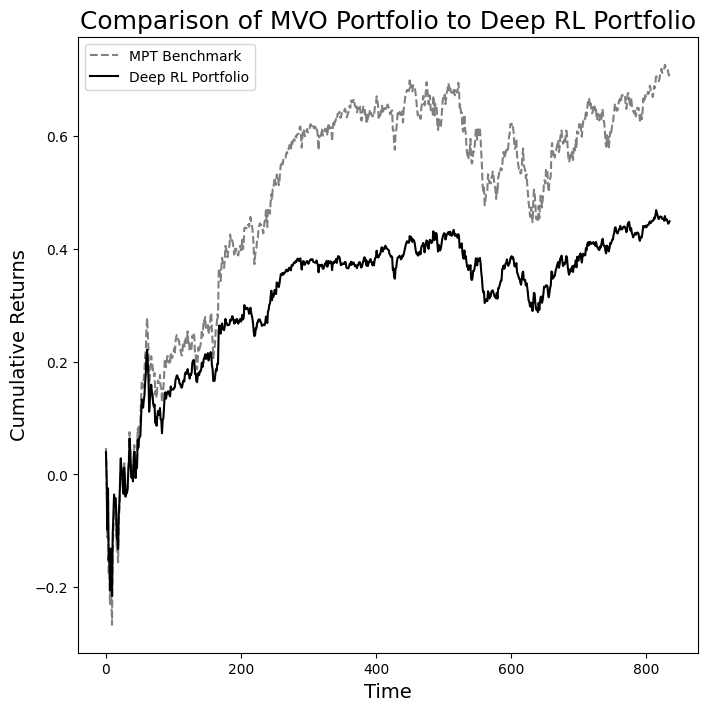

In [44]:
# Create a new figure
plt.figure(figsize=(8,8))

# Plot the cumulative returns of the benchmark portfolio (MPT weighted)
plt.plot(np.array(returns_mpt_list).cumsum(), label='MPT Benchmark', color='grey', ls='--')

# Plot the cumulative returns of the Deep RL portfolio
plt.plot(np.array(returns_rl_list).cumsum(), label='Deep RL Portfolio', color='black', ls='-')

# Add labels and legend to the plot
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Cumulative Returns', fontsize = 14)
plt.title("Comparison of MVO Portfolio to Deep RL Portfolio", fontsize=18)
plt.legend()

# Display the plot
plt.show();

# plt.savefig('../images/RL_vs_MPT_comparison.png', dpi=1000)

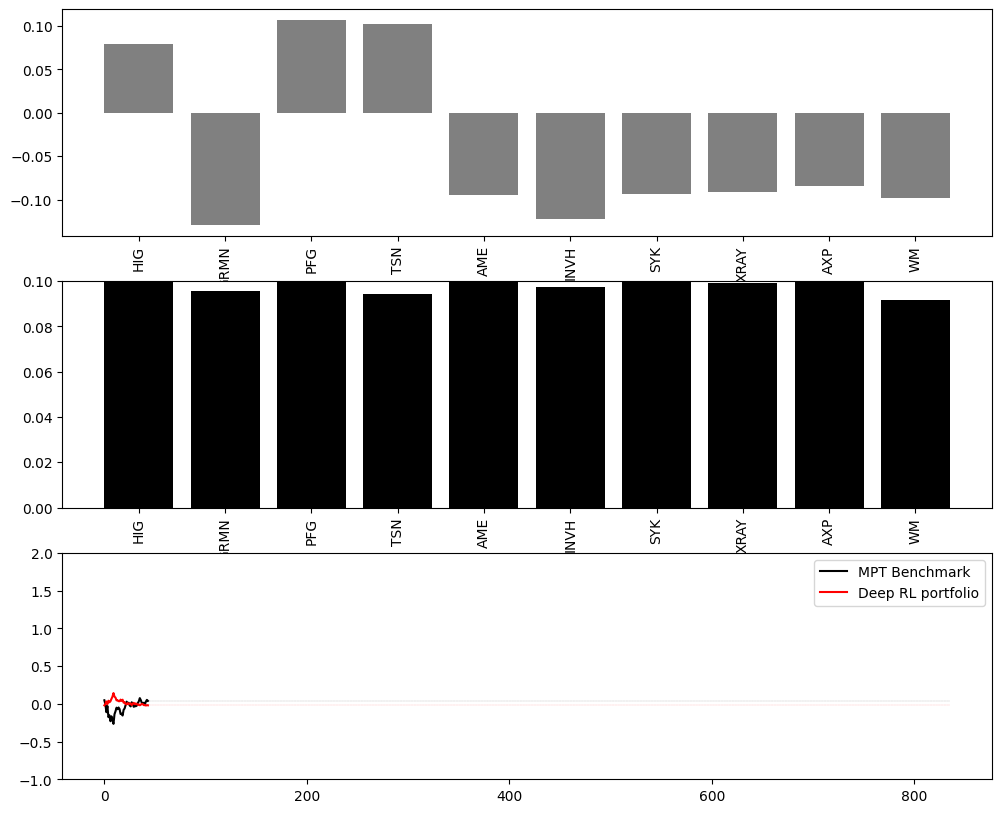

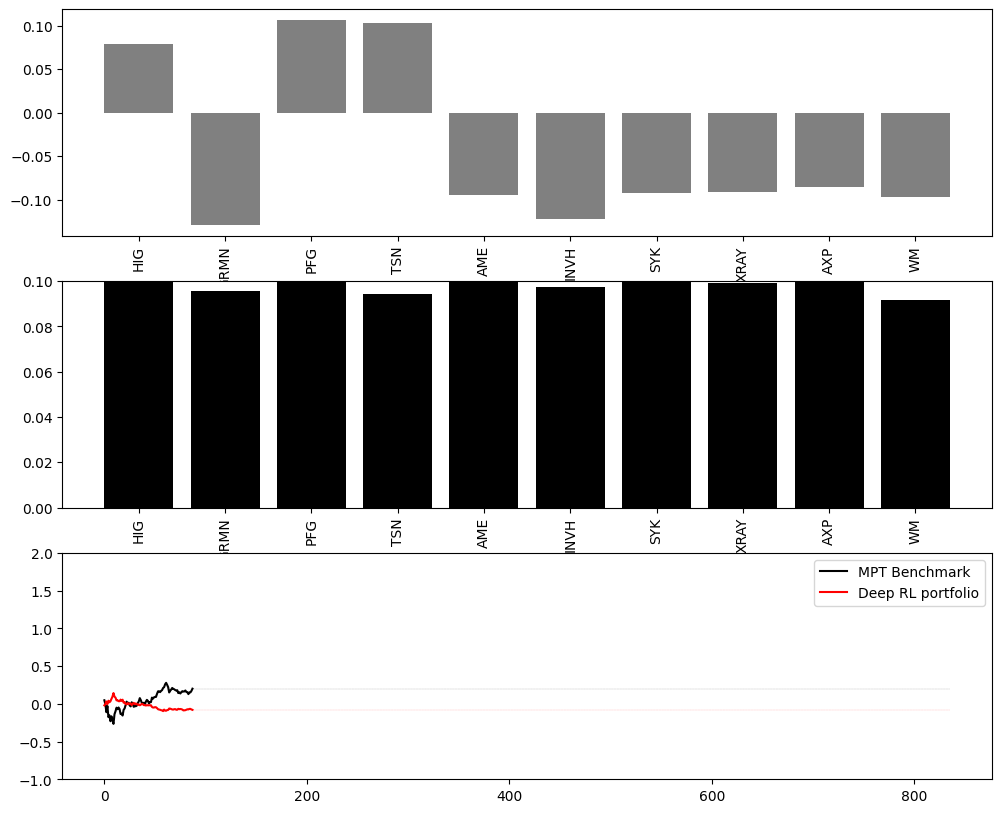

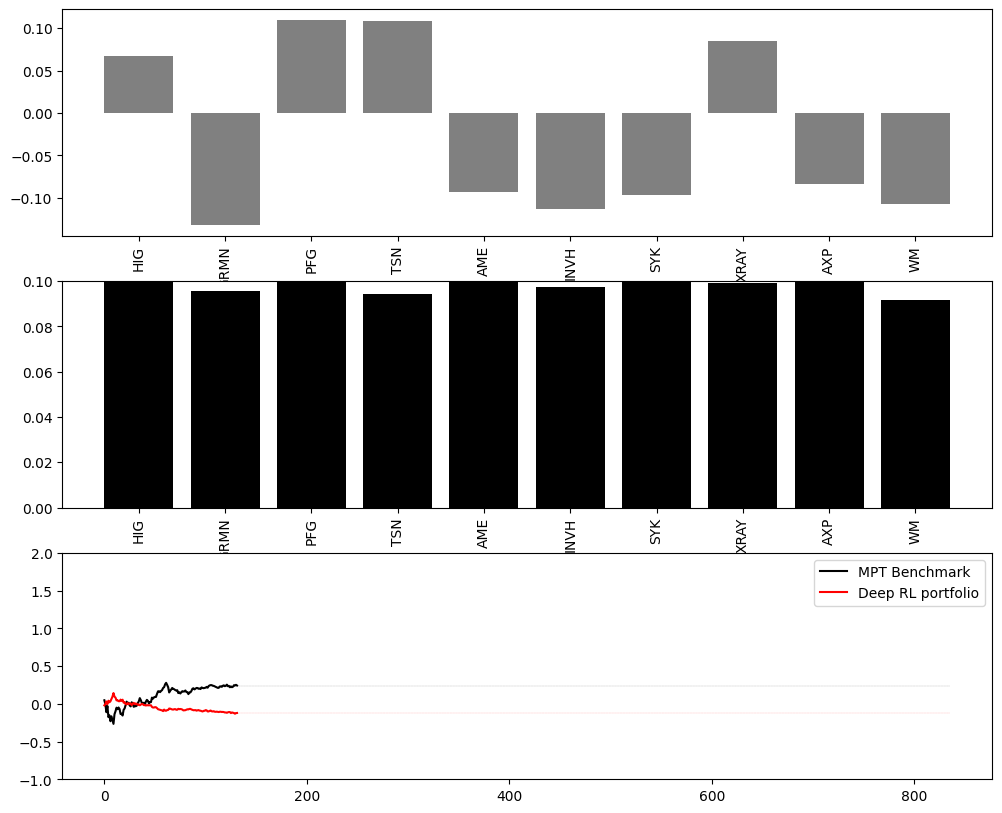

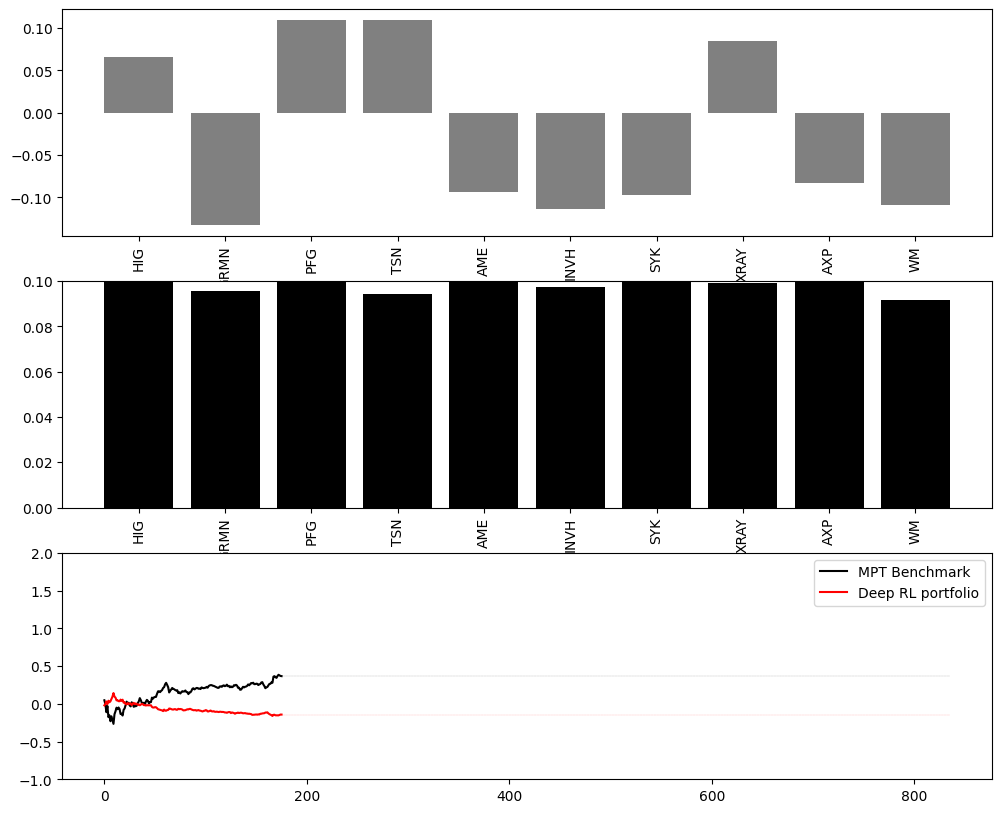

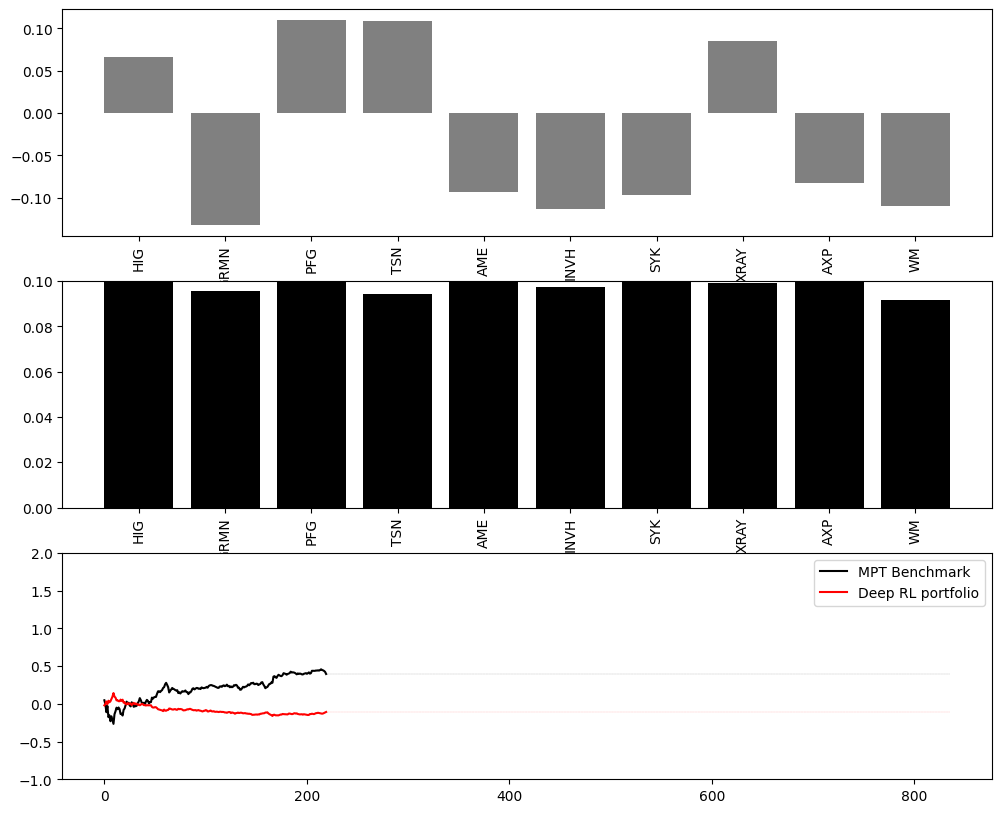

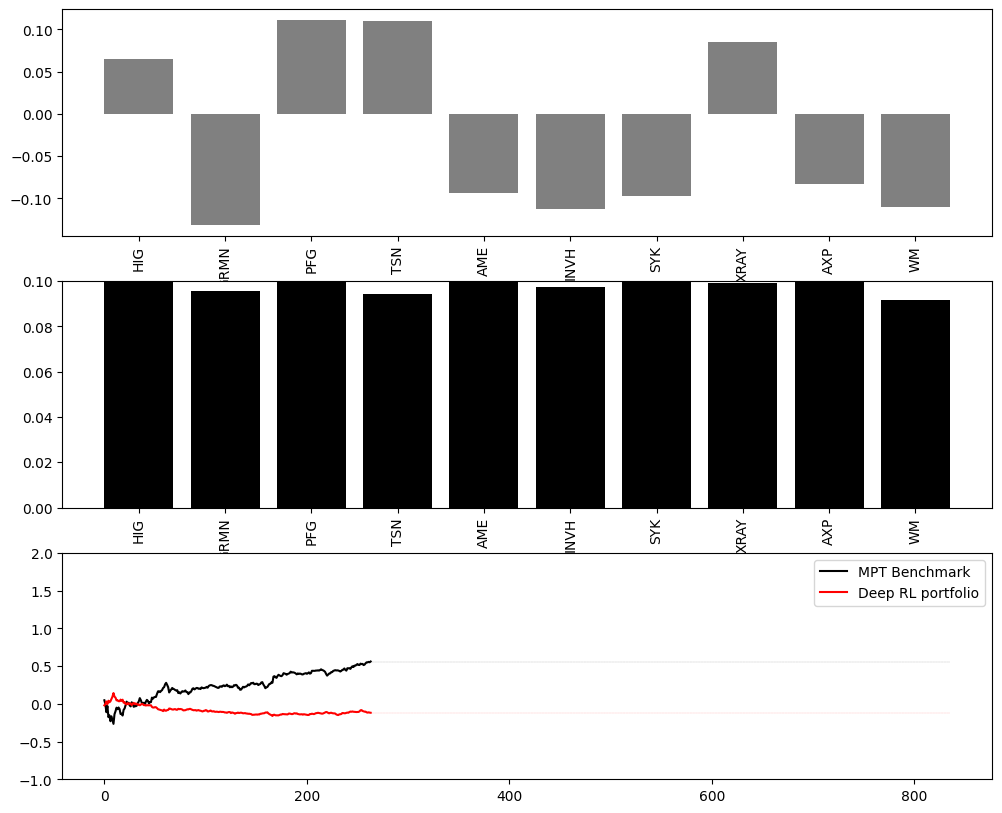

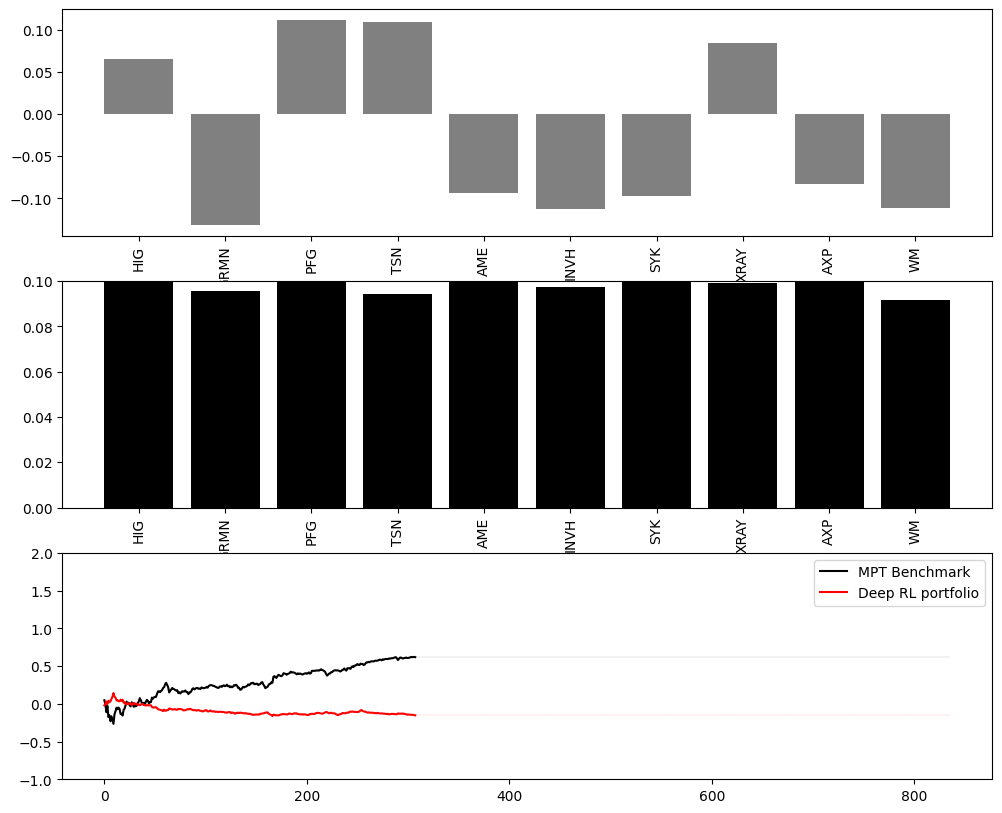

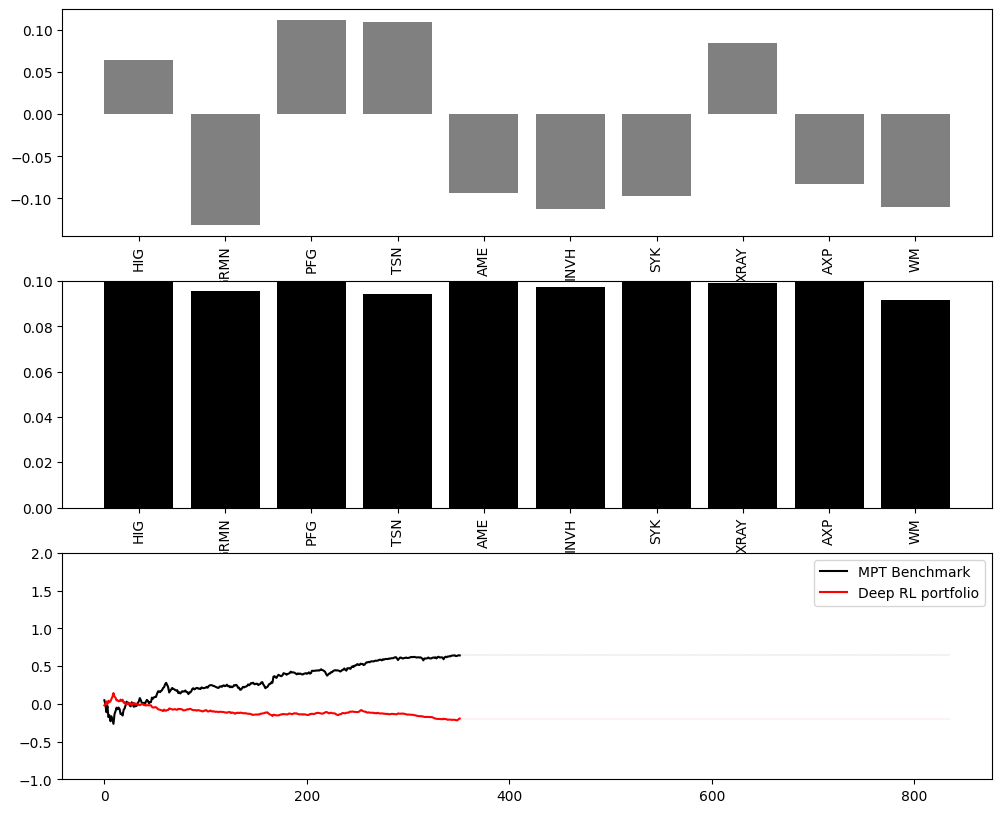

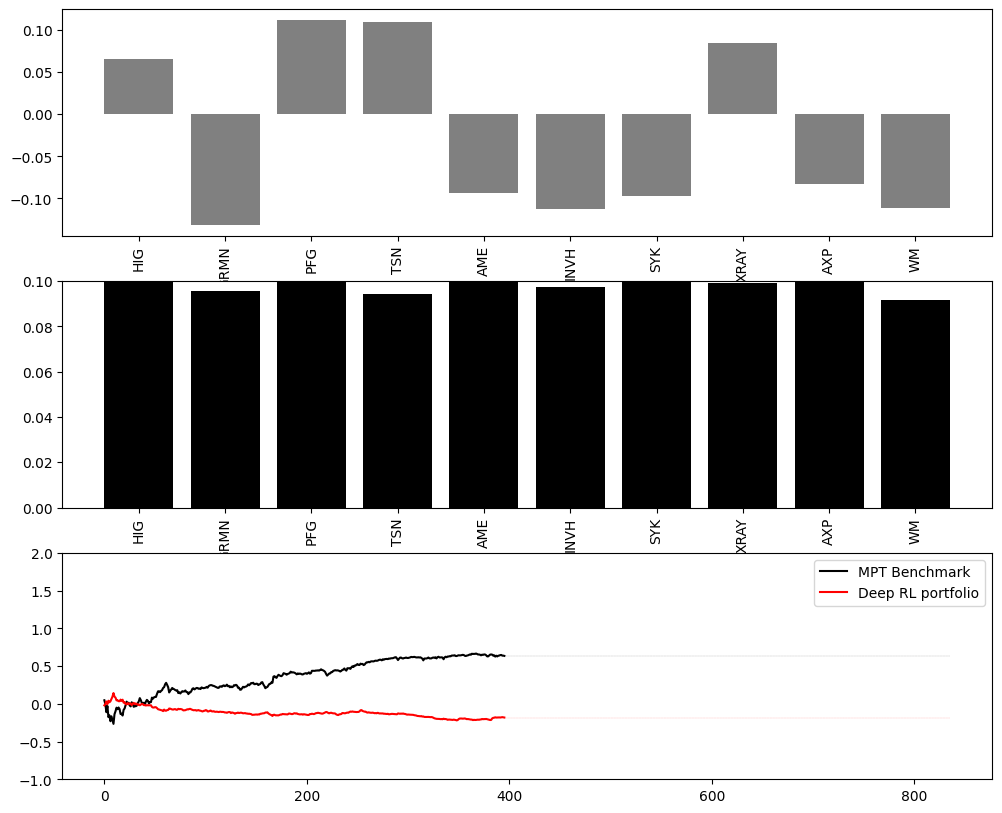

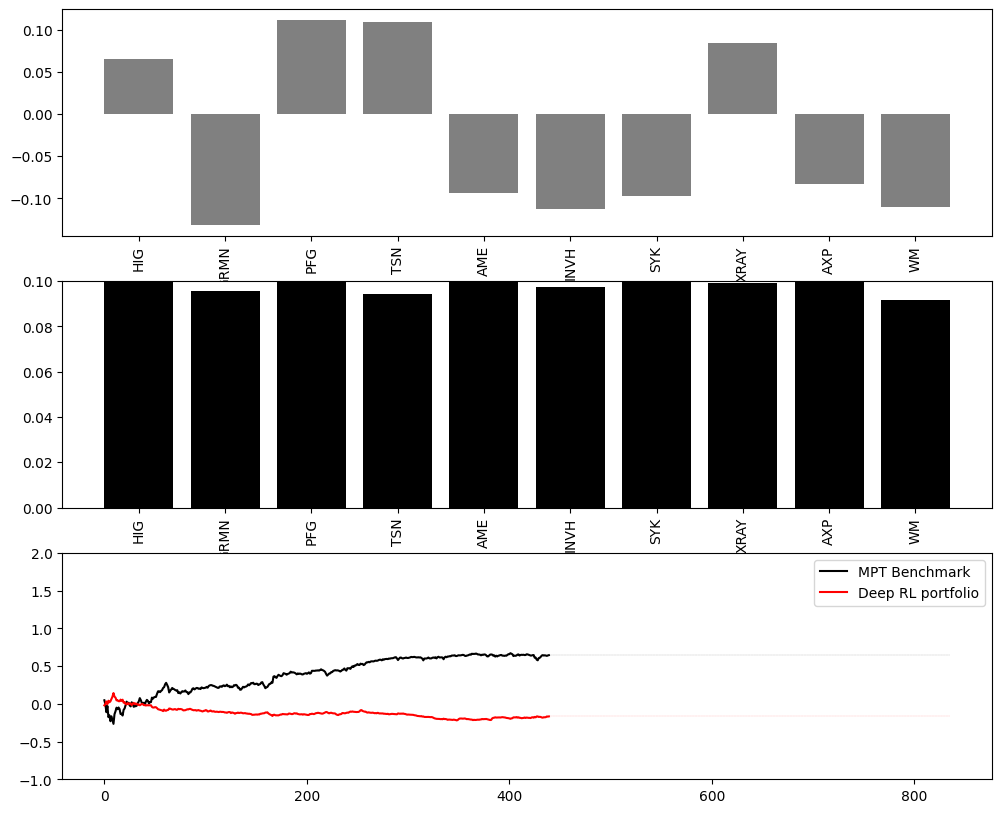

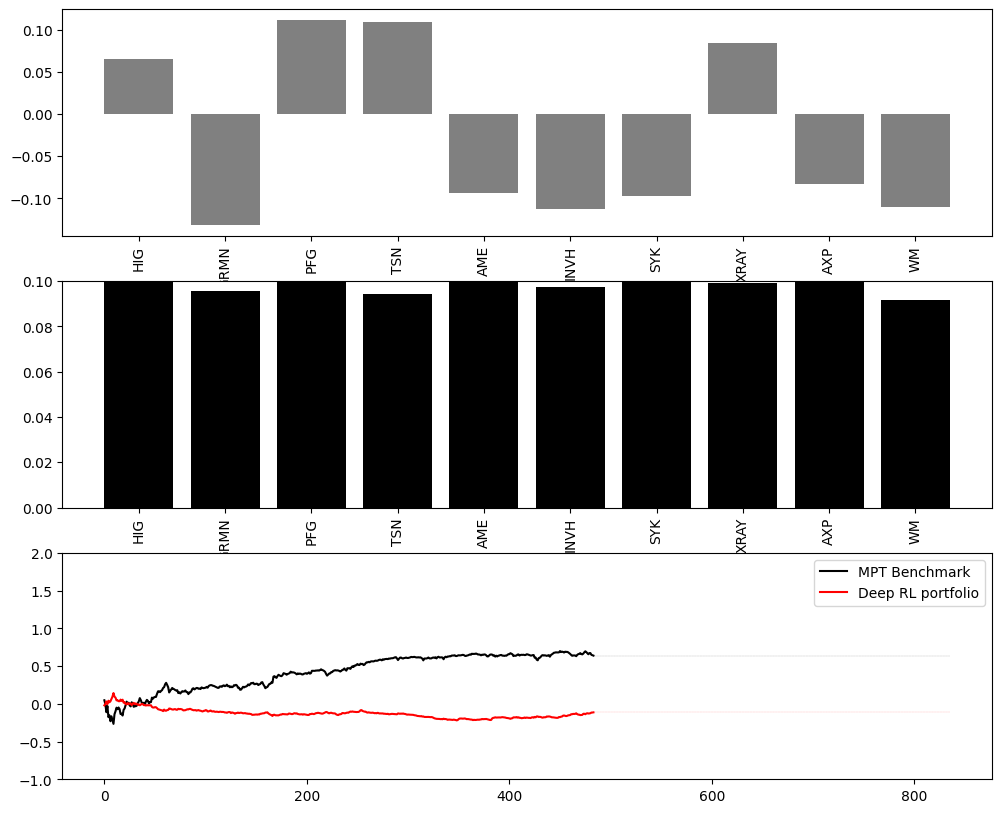

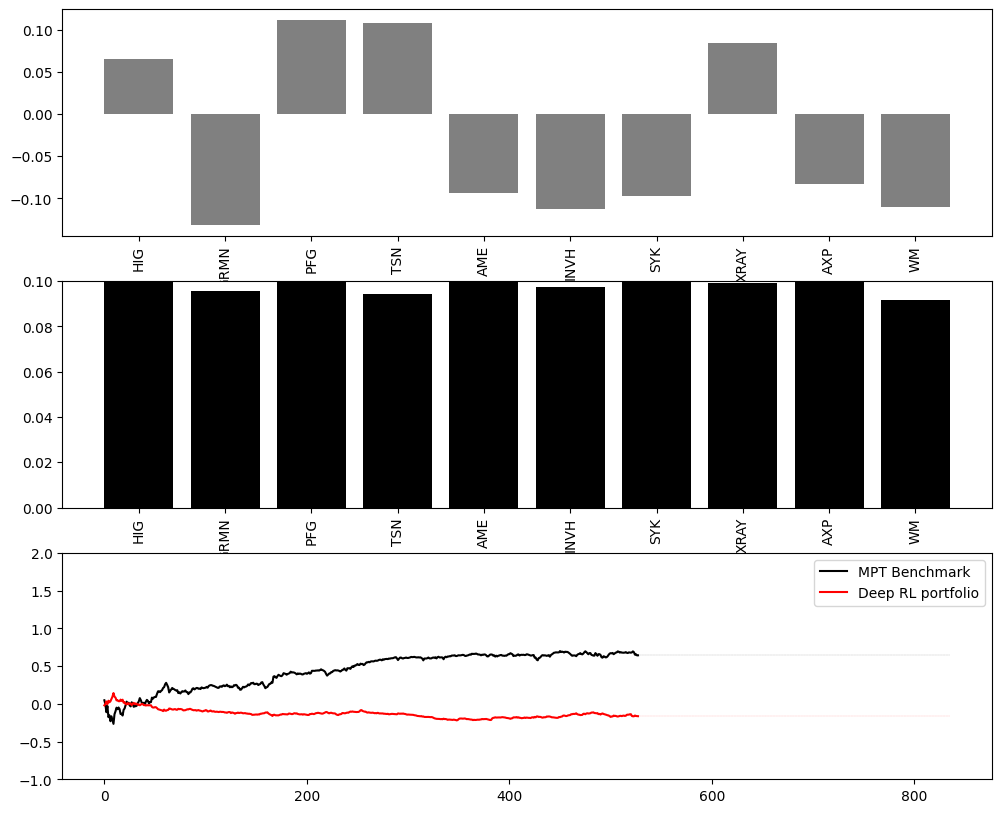

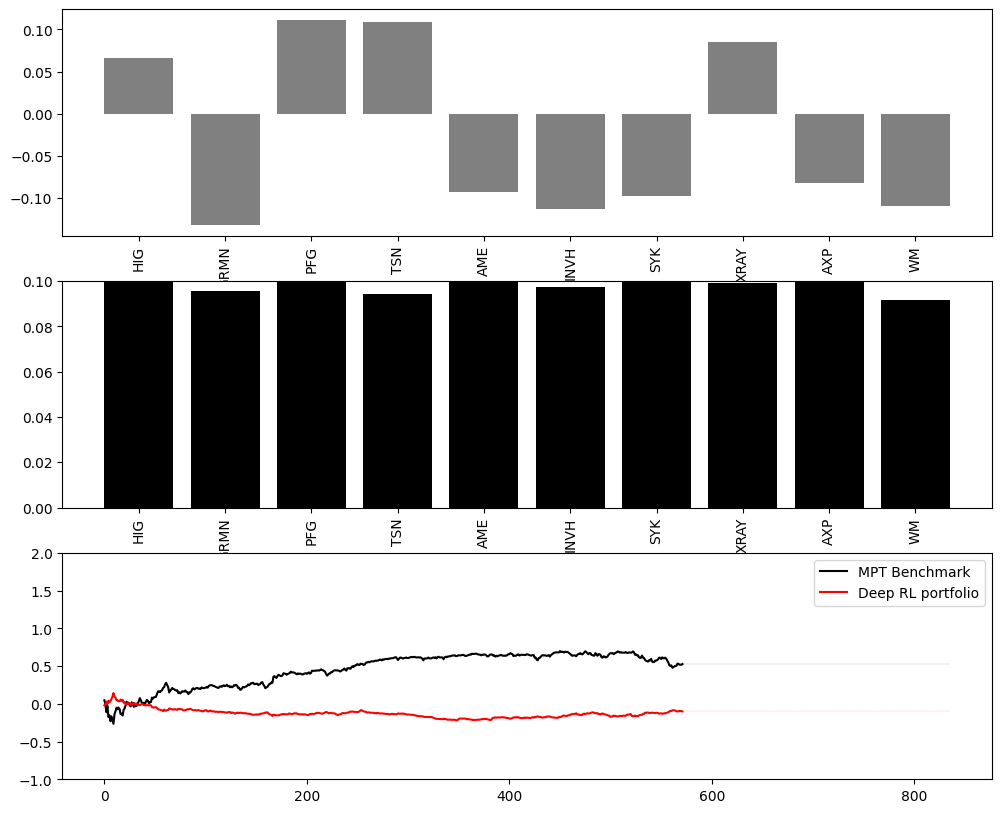

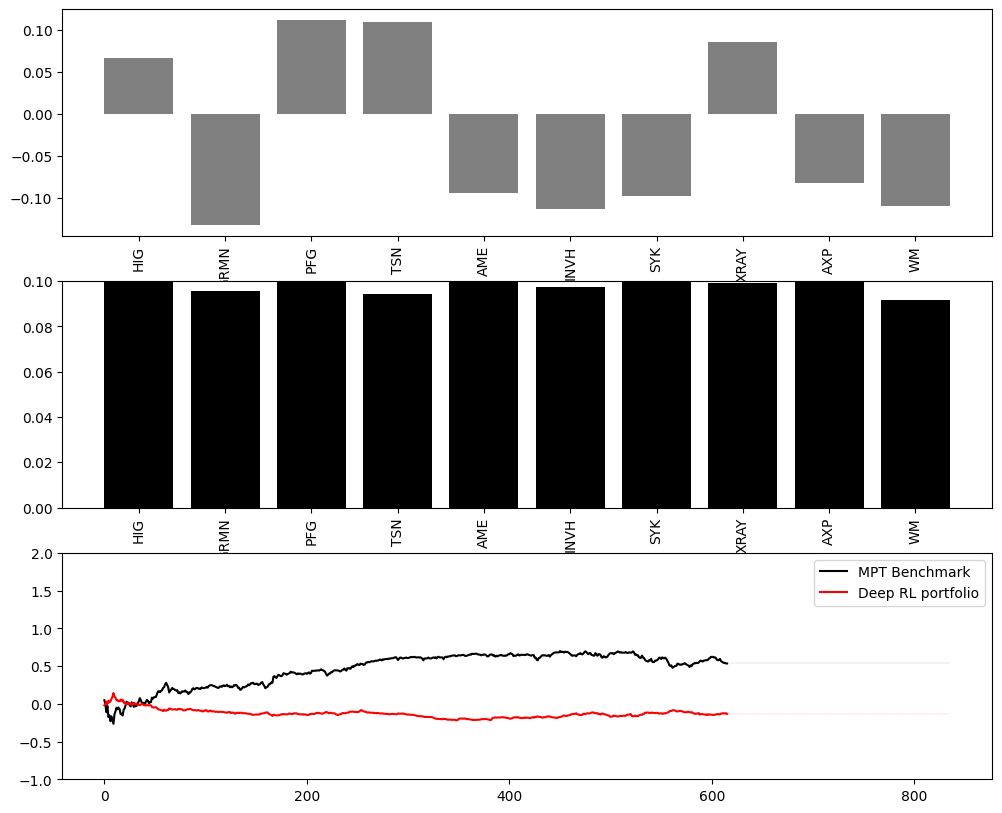

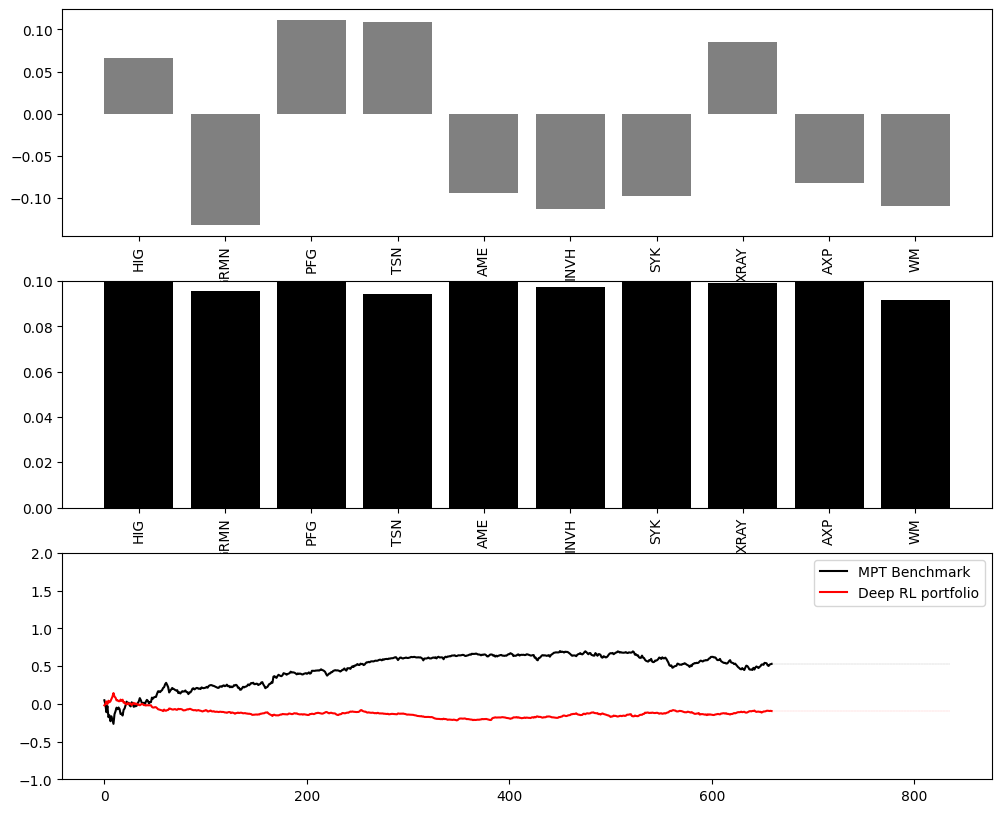

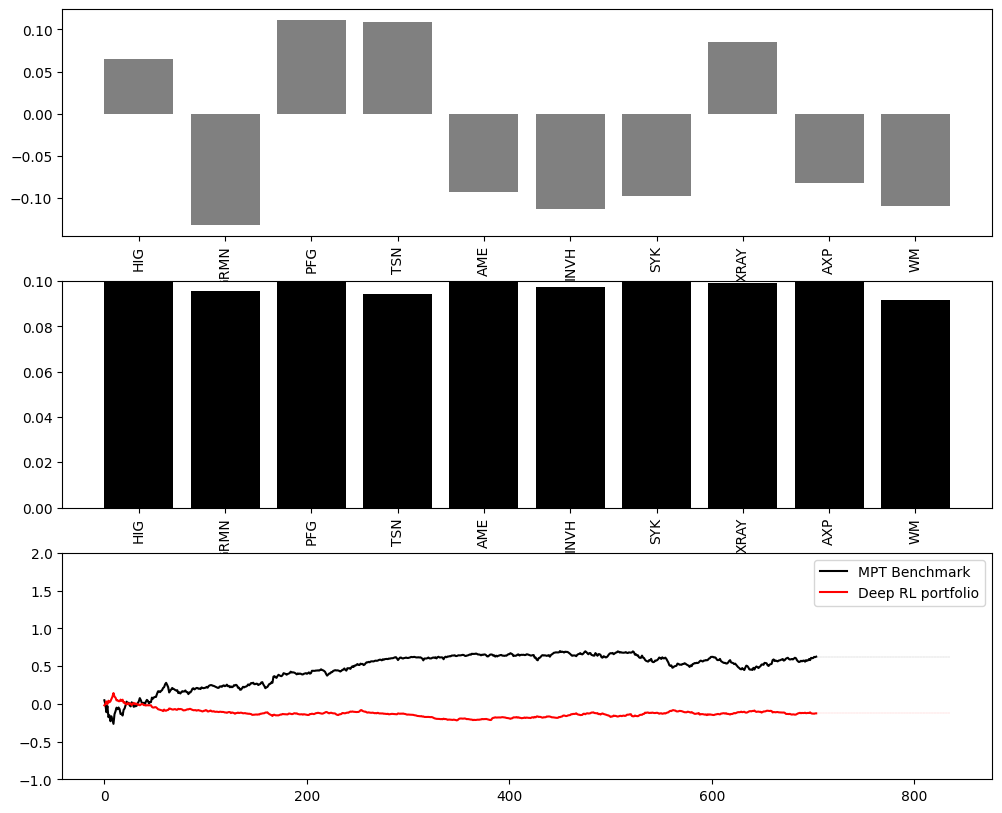

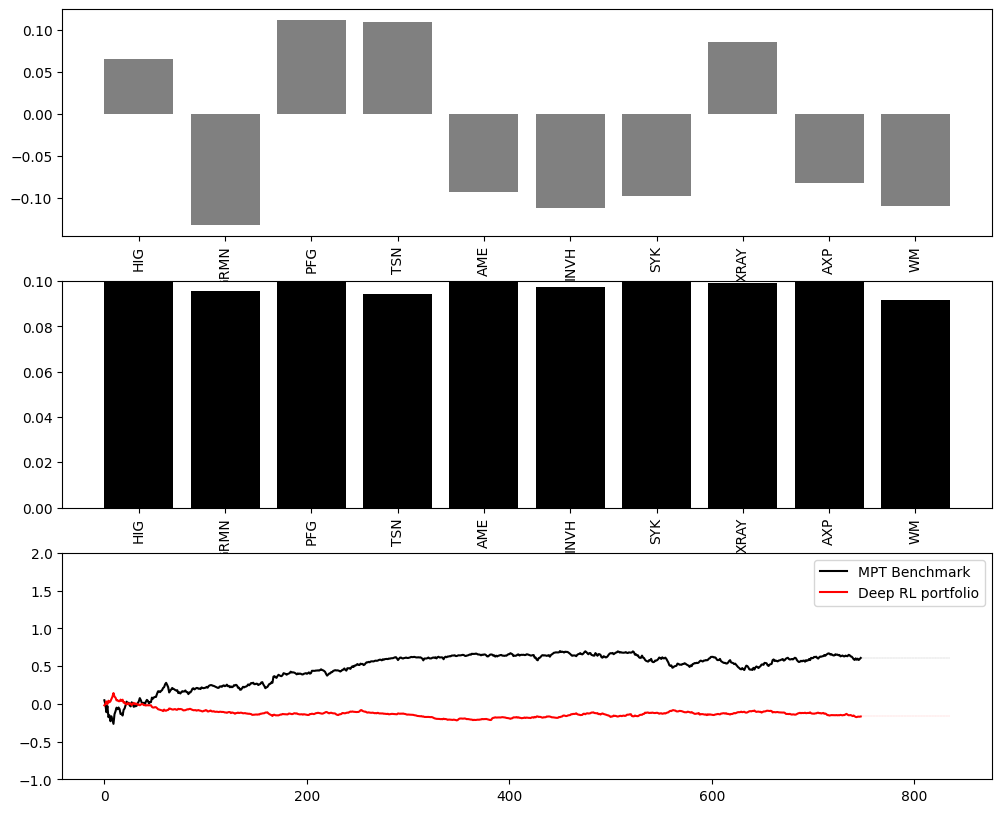

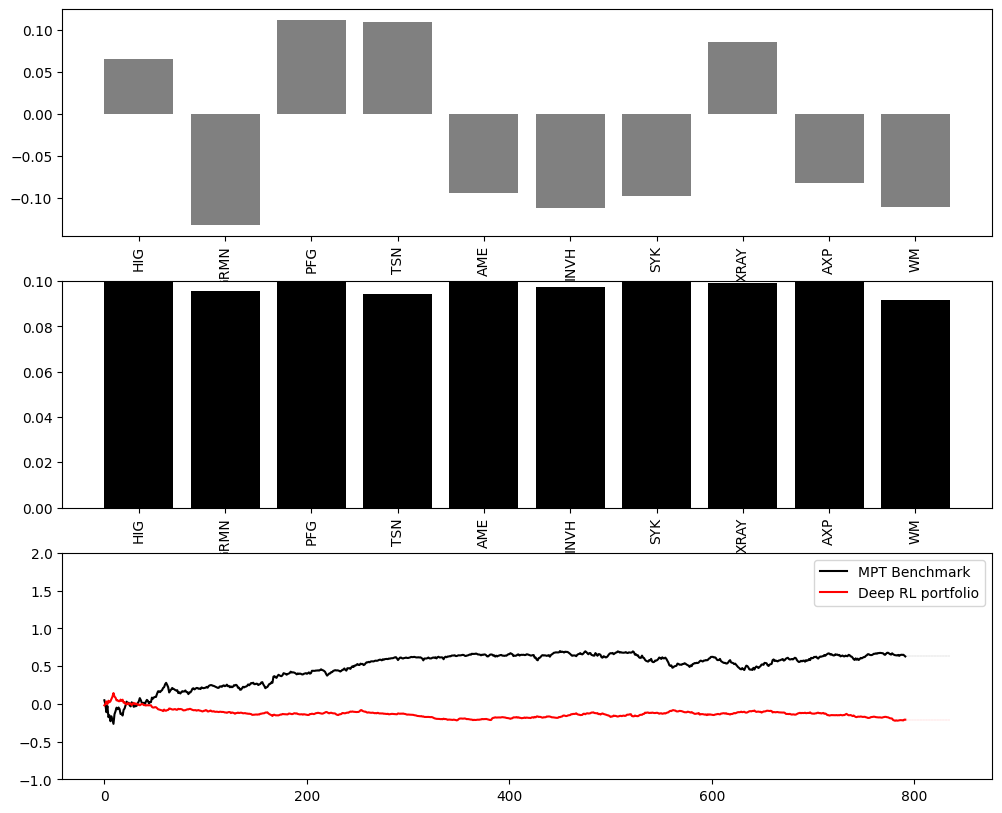

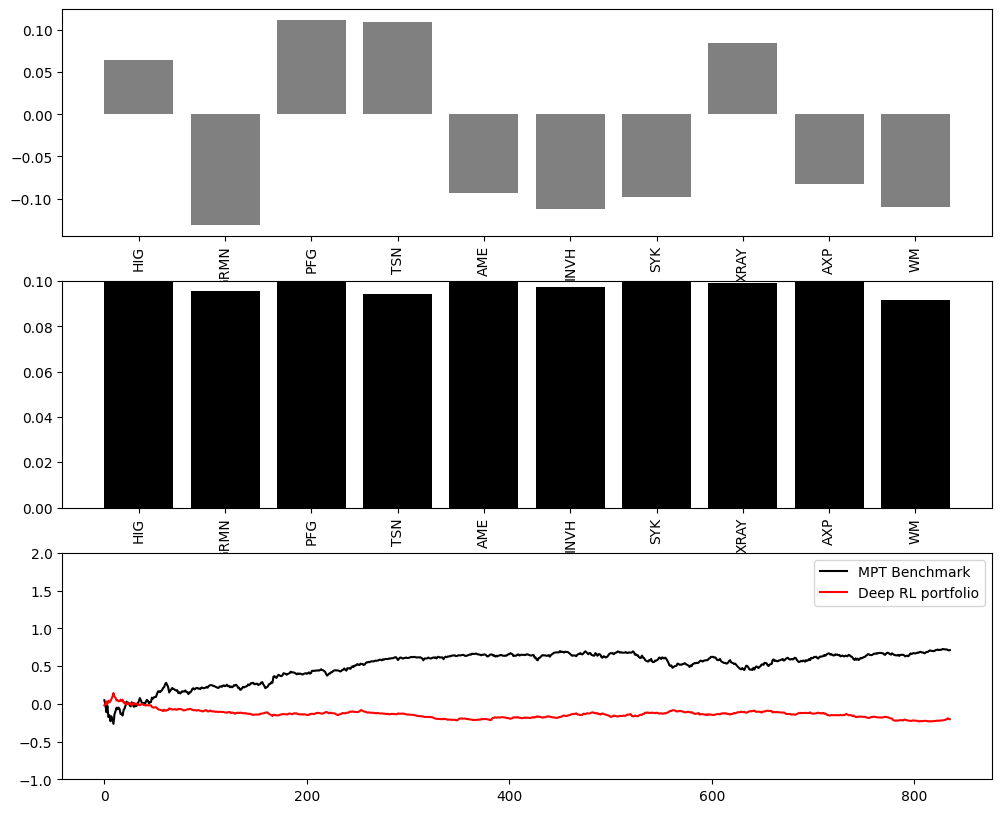

In [35]:
# Calculate the length of cumulative returns data
N = len(np.array([item for sublist in returns_mpt for item in sublist]).cumsum())

# Loop through different time steps
for i in range(0, len(actions_rl)):
    # Initialize arrays to store time series data
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    # Calculate cumulative returns for the benchmark and Deep RL portfolio
    ts_benchmark = np.array([item for sublist in returns_mpt[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in returns_rl[:i+1] for item in sublist]).cumsum()
    
    # Determine the length of the current time series data
    t = len(ts_benchmark)
    
    # Assign cumulative returns to the current time series arrays
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target
    
    # Fill zero values with the last available value to avoid gaps in the plot
    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    # Create a new figure for plotting
    plt.figure(figsize=(12, 10))

    # Create three subplots, one for portfolio allocation for the Deep RL portfolio, one for the MPT weighted portfolio and one for cumulative returns
    plt.subplot(3, 1, 1)
    plt.bar(np.arange(n_assets), actions_rl[i], color='grey')
    plt.xticks(np.arange(n_assets), env.data.columns, rotation='vertical')

    plt.subplot(3, 1, 2)
    plt.bar(np.arange(n_assets), actions_mpt[i], color='black')
    plt.xticks(np.arange(n_assets), env.data.columns, rotation='vertical')
    plt.ylim([0, 0.1])

    plt.subplot(3, 1, 3)
    # Plot cumulative returns for the MPT benchmark (black line) and Deep RL portfolio (red line)
    plt.plot(current_range[:t], current_ts[:t], color='black', label='MPT Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color='red', label='Deep RL portfolio')

    # Plot dashed lines for time steps beyond the available data
    plt.plot(current_range[t:], current_ts[t:], ls='--', lw=0.1, color='black')
    plt.plot(current_range[t:], current_ts2[t:], ls='--', lw=0.1, color='red')

    # Set the y-axis limits
    plt.ylim([-1, 2])

    # Add a legend to differentiate between the MPT benchmark and Deep RL portfolio
    plt.legend()


## 6.1 Statistical Metrics To Compare RL Agent Against the MVO Portfolio

In [36]:
def sharpe(R):
    """
    Calculate the Sharpe ratio for a given time series of returns.

    Parameters:
    - R (np.array): Array of returns.

    Returns:
    - sr (float): Sharpe ratio for the input returns.
    
    The Sharpe ratio measures the risk-adjusted return and is calculated as the mean of returns divided by
    the standard deviation of returns, scaled by the square root of the number of trading days per year (252).
    """
    r = np.diff(R)
    sr = r.mean() / r.std() * np.sqrt(252)
    return sr


In [37]:
def print_stats(result, benchmark):
    """
    Calculate and print various statistical metrics for a portfolio's performance compared to a benchmark.

    Parameters:
    - result (list): List of cumulative returns for the portfolio.
    - benchmark (list): List of cumulative returns for the benchmark.

    Returns:
    - stats (list): List of calculated statistics, including returns, volatility, Sharpe ratio, alpha, and beta.
    
    This function calculates and prints statistics for the portfolio's performance compared to a benchmark. 
    The calculated statistics include:
    - Returns: The mean of cumulative returns.
    - Volatility: The standard deviation of cumulative returns.
    - Sharpe Ratio: The risk-adjusted return.
    - Alpha: The intercept of the linear regression model (CAPM).
    - Beta: The slope of the linear regression model (CAPM).
    """
    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [38]:
# Print the statistical metrics for the MPT benchmark and the RL Agent
print('MPT BENCHMARK', print_stats(returns_mpt_list, returns_mpt_list))
print('RL AGENT', print_stats(returns_rl_list, returns_mpt_list))

MPT BENCHMARK [0.0009, 0.0171, 0.74, 0.0, 1.0]
RL AGENT [-0.0002, 0.0072, -0.4897, -0.0, -0.2448]
